<a href="https://colab.research.google.com/github/elangbijak4/Security_Research/blob/main/Tool21_Almudaya_GPU_Evolution_Algorithm_For_Algorithm_Discovery_on_Cyber_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.1 MB/s eta 0:00:00


In [2]:
import operator
import random
import numpy as np
import pandas as pd
from deap import algorithms, base, creator, gp, tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import functools
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
# Load dataset (NSL-KDD)
url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt"
column_names = [  # Sesuaikan dengan nama kolom dataset NSL-KDD
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
    'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
    'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label'
]
data = pd.read_csv(url, header=None, names=column_names)

In [4]:
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,tcp,ftp_data,SF,491,0,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
0,udp,other,SF,146,0,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
0,tcp,private,S0,0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
0,tcp,http,SF,232,8153,0,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
0,tcp,http,SF,199,420,0,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [5]:
# Preprocessing data
# Encode categorical features
categorical_columns = ['duration','protocol_type', 'service', 'flag','dst_host_srv_rerror_rate']
le_dict = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    le_dict[col] = le  # Save the label encoder for possible inverse_transform later

X = data.iloc[:, :-1].values  # Fitur
y = data.iloc[:, -1].values  # Label

In [6]:
# Encode label
y = np.where(y == 'normal', 0, 1)

In [7]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [8]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).cuda()
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).cuda()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).cuda()
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).cuda()

In [10]:
# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = SimpleNN(X_train.shape[1]).cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Training the model
def train_model():
    model.train()
    for epoch in range(100):  # Number of epochs
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs.squeeze(), y_train_tensor)
        loss.backward()
        optimizer.step()

In [12]:
# Evaluate the model
def evaluate_model():
    model.eval()
    with torch.no_grad():
        outputs = model(X_train_tensor)
        predictions = (outputs.squeeze() > 0.5).float()
        accuracy = accuracy_score(y_train_tensor.cpu(), predictions.cpu())
    return accuracy

In [13]:
# Buat tipe individu dan fitness
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

In [14]:
# Buat Primitive Set untuk GP
pset = gp.PrimitiveSet("MAIN", X_train.shape[1])
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.neg, 1)
pset.addEphemeralConstant("rand101", functools.partial(random.uniform, -1, 1))

In [15]:
# Buat toolbox untuk GP
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("compile", gp.compile, pset=pset)

In [20]:
# Define evaluation function
def evaluate(individual):
    func = toolbox.compile(expr=individual)
    # Transform the dataset based on the GP individual
    transformed_X_train = np.array([func(*x) for x in X_train])

    # Check if transformed_X_train is empty and handle it
    if transformed_X_train.size == 0:
        return -1,  # Return a low fitness value to penalize unproductive individuals

    # Ensure transformed_X_train is 2D for shape[1] to work
    if transformed_X_train.ndim == 1:
        transformed_X_train = transformed_X_train.reshape(-1, 1)  # Reshape to a 2D array with one column

    # Convert transformed_X_train to a PyTorch tensor
    transformed_X_train_tensor = torch.tensor(transformed_X_train, dtype=torch.float32).cuda()

    # Re-train the model on the transformed data
    model = SimpleNN(transformed_X_train.shape[1]).cuda()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    for epoch in range(100):  # Number of epochs
        optimizer.zero_grad()
        outputs = model(transformed_X_train_tensor)
        loss = criterion(outputs.squeeze(), y_train_tensor)
        loss.backward()
        optimizer.step()

    # Evaluate the model
    with torch.no_grad():
        outputs = model(transformed_X_train_tensor)
        predictions = (outputs.squeeze() > 0.5).float()
        accuracy = accuracy_score(y_train_tensor.cpu(), predictions.cpu())

    return accuracy,

In [21]:
toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [22]:
# Inisialisasi parameter evolusi
population = toolbox.population(n=300)
hall_of_fame = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [23]:
# Jalankan algoritma evolusi
population, log = algorithms.eaSimple(population, toolbox, 0.5, 0.2, 40, stats=stats, halloffame=hall_of_fame, verbose=True)

gen	nevals	avg	std	min	max
0  	300   	1  	0  	1  	1  
1  	185   	1  	0  	1  	1  
2  	190   	1  	0  	1  	1  
3  	167   	1  	0  	1  	1  
4  	183   	1  	0  	1  	1  
5  	193   	1  	0  	1  	1  
6  	185   	1  	0  	1  	1  
7  	187   	1  	0  	1  	1  
8  	187   	1  	0  	1  	1  
9  	186   	1  	0  	1  	1  
10 	177   	1  	0  	1  	1  
11 	197   	1  	0  	1  	1  
12 	179   	1  	0  	1  	1  
13 	188   	1  	0  	1  	1  
14 	180   	1  	0  	1  	1  
15 	171   	1  	0  	1  	1  
16 	169   	1  	0  	1  	1  
17 	165   	1  	0  	1  	1  
18 	178   	1  	0  	1  	1  
19 	182   	1  	0  	1  	1  
20 	147   	1  	0  	1  	1  
21 	180   	1  	0  	1  	1  
22 	190   	1  	0  	1  	1  
23 	175   	1  	0  	1  	1  
24 	187   	1  	0  	1  	1  
25 	198   	1  	0  	1  	1  
26 	198   	1  	0  	1  	1  
27 	170   	1  	0  	1  	1  
28 	172   	1  	0  	1  	1  
29 	159   	1  	0  	1  	1  
30 	181   	1  	0  	1  	1  
31 	180   	1  	0  	1  	1  
32 	181   	1  	0  	1  	1  
33 	185   	1  	0  	1  	1  
34 	195   	1  	0  	1  	1  
35 	178   	1  	0  	1  	1  
3

In [24]:
# Tampilkan hasil terbaik
best_individual = hall_of_fame[0]
print("Best individual: ", best_individual)
print("Fitness: ", best_individual.fitness.values)

Best individual:  add(ARG6, ARG21)
Fitness:  (1.0,)


In [38]:
import torch.nn as nn
import torch.nn.functional as F

class ModifiedModel(nn.Module):
    def __init__(self, input_size=42, hidden_size=50):
        super(ModifiedModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Inisialisasi model dengan input_size yang disesuaikan
model = ModifiedModel(input_size=42).cuda()

In [39]:
# Asumsikan 'best_individual' sudah didefinisikan sebelumnya
func = toolbox.compile(expr=best_individual)

# Transformasi data uji dengan individu terbaik dari GP
transformed_X_test = []
for x in X_test:
    result = func(*x)
    # Gabungkan hasil transformasi dengan fitur asli
    combined_features = np.append(x, result)
    transformed_X_test.append(combined_features)

# Konversi ke array numpy
transformed_X_test = np.array(transformed_X_test)

# Debugging: cetak bentuk dari array yang dihasilkan
print("Bentuk transformed_X_test sebelum reshape: ", transformed_X_test.shape)
print("Contoh elemen transformed_X_test: ", transformed_X_test[0])

# Asumsikan model mengharapkan input dengan num_features = 41 + 1 (fitur asli + hasil transformasi)
num_features = 41 + 1

# Jika bentuknya tidak sesuai, lakukan reshape
if len(transformed_X_test.shape) == 1:
    # Jika hanya satu dimensi, reshape menjadi (-1, num_features)
    if transformed_X_test.shape[0] % num_features != 0:
        raise ValueError("Jumlah elemen tidak bisa dibagi rata menjadi num_features")
    transformed_X_test = transformed_X_test.reshape(-1, num_features)
elif transformed_X_test.shape[1] != num_features:
    raise ValueError(f"Bentuk data tidak sesuai: {transformed_X_test.shape[1]} fitur ditemukan, tetapi {num_features} diharapkan.")

# Pastikan bentuk tensor yang dihasilkan sesuai dengan model
transformed_X_test_tensor = torch.tensor(transformed_X_test, dtype=torch.float32).cuda()

# Pastikan tensor target memiliki bentuk yang sesuai
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).cuda()

# Uji model dengan data yang ditransformasikan
with torch.no_grad():
    outputs = model(transformed_X_test_tensor)
    test_predictions = (outputs.squeeze() > 0.5).float()
    test_accuracy = accuracy_score(y_test_tensor.cpu(), test_predictions.cpu())

print("Test Accuracy: ", test_accuracy)

Bentuk transformed_X_test sebelum reshape:  (37792, 42)
Contoh elemen transformed_X_test:  [ 2.21931185 -1.17618945  0.75111129 -0.41749354 -0.00491864 -0.01408881
 -0.08948642 -0.00773599 -0.09507567 -0.02702282 -0.80926182 -0.01166364
 -0.03665187 -0.02443651 -0.01238515 -0.02618002 -0.0186099  -0.0412212
  0.         -0.00281749 -0.09753094 -0.71704549 -0.32680812 -0.63720927
 -0.63192903 -0.37436224 -0.3744316   0.77128311 -0.34968303  2.51194893
 -1.16070756  0.49996246  1.06640135 -0.43907817  2.75609201 -0.20026454
 -0.63953191 -0.6248708  -0.38763462 -0.37638703  0.14207372 -0.80653191]
Test Accuracy:  0.4963219729043184


In [40]:
import matplotlib.pyplot as plt
import networkx as nx
from deap import gp

In [41]:
def plot_tree(individual):
    nodes, edges, labels = gp.graph(individual)

    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = nx.spring_layout(g)

    nx.draw_networkx_nodes(g, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels)
    plt.show()

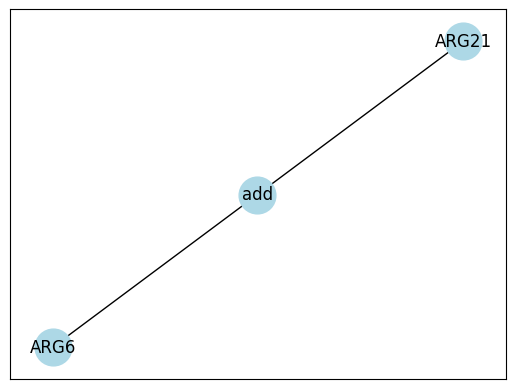

In [42]:
# Visualisasi pohon terbaik
plot_tree(best_individual)

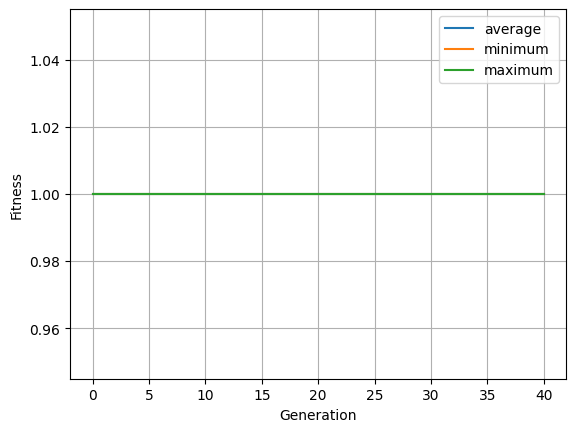

In [43]:
# Plotting fitness score over generations
gen = log.select("gen")
avg = log.select("avg")
min_ = log.select("min")
max_ = log.select("max")

plt.figure()
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.plot(gen, max_, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="best")
plt.grid(True)
plt.show()

Uji Coba Model atau Algoritma yang ditemukan oleh penerapan Algoritma Evolusi pada dataset

In [44]:
import random
from sklearn.metrics import accuracy_score, confusion_matrix # Import confusion_matrix

# Ambil secara acak 100 titik data dari dataset
random_indices = random.sample(range(len(X)), 100)
X_test_random = X[random_indices]
y_test_random = y[random_indices]

# Evaluasi model terbaik pada data acak
test_predictions_random = np.array([func(*x) for x in X_test_random])
test_predictions_random = np.round(test_predictions_random).astype(int)
test_accuracy_random = accuracy_score(y_test_random, test_predictions_random)

print("Accuracy on random 100 data points: ", test_accuracy_random)
print("Confusion Matrix on random 100 data points:")
print(confusion_matrix(y_test_random, test_predictions_random)) # Now confusion_matrix is defined

Accuracy on random 100 data points:  0.14
Confusion Matrix on random 100 data points:
[[ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [60 17 14  7  1  1]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]]
